### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import euclidean, cdist
from scipy.special import softmax
import matplotlib.pyplot as plt

In [2]:
sim_data = pd.read_csv('gmm6_allvar_0_simbad.csv')

In [3]:
sim_df = sim_data[['col1', 'name', 'main_type', 'cluster', 'prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']]
prob_cols = ['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']

In [4]:
sim_df_clean = sim_data.copy().fillna({'main_type': 'NaN'})

In [5]:
features = ['theta', 'src_area_b', 'hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h', 'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m', 'kp_prob_s']

features_lognorm = ['theta', 'src_area_b', 'bb_kt', 'var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m',  'var_sigma_s', 'var_mean_s', 'var_min_s', 'var_max_s']

features_norm = ['powlaw_gamma']

X = sim_df_clean.copy().to_numpy()

In [6]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [7]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(sim_df_clean, X, feature, True)
        
for feature in features_norm:
    X = lognorm(sim_df_clean, X, feature, False)

In [8]:
s_df = pd.DataFrame(X, columns=sim_df_clean.columns)

In [9]:
def create_summary_tables(df):
    data_n = df.copy()
    count_obs = data_n.groupby(['main_type']).size()
    df_n = pd.concat([count_obs], axis=1)
    df_n = df_n.rename(columns={0:'size'})
    return df_n

def softmin(x):
    return np.exp(-np.abs(x))/sum(np.exp(-np.abs(x)))

# Use abs with cosine metric
def frequent_types(df, n, uks):
    if uks:
        df = df[(df.main_type != 'NaN') & ~(df.main_type.isin(uks))]
    else:
        df = df[df.main_type != 'NaN']
    count_obs = df.groupby(['main_type']).size()
    count_obs_df = count_obs.reset_index()
    count_obs_df = count_obs_df.rename(columns={0:'size'})
    quer = count_obs_df.sort_values(by='size', ascending=False).head(n)
    ltypes = np.unique(quer.main_type)
    return ltypes

def gen_nan_probs(cl, features, uks=[], mean=True):
    if uks:
        cl_nan = cl[(cl.main_type == 'NaN') | cl.main_type.isin(uks)]
    else:
        cl_nan = cl[cl.main_type == 'NaN']

    cl_types_desc = cl_nan[features]
    ltypes = frequent_types(cl, 5, uks=uks)
    types_comp = []
    types_prob = []
    for i, row in cl_types_desc.iterrows():
        r_np = row.to_numpy().reshape(1, -1)

        mdists = []
        for t in ltypes:
            cl_type = cl[cl.main_type == t]
            cl_type_desc = cl_type[features]
            cltd_np = cl_type_desc.to_numpy()
            d2t = cdist(r_np, cltd_np, metric='mahalanobis')
            if mean:
                d2t_mean = np.mean(d2t)
            else:
                d2t_mean = np.median(d2t)

            mdists.append(d2t_mean)

        scaler = MinMaxScaler()
        mdistsn = np.asarray(mdists).reshape(-1, 1)
        #mdistsn = scaler.fit_transform(mdistsn)
        mdistsn = mdistsn.ravel()
        sm_probs = softmin(mdistsn)
        types_prob.append(sm_probs)
        t_amax = np.argmax(sm_probs)
        types_comp.append(ltypes[t_amax])

    #print(cl_nan.name.to_numpy(), np.array(types_prob), types_comp)
    out_l = pd.DataFrame(cl_nan[['name', 'obsid']])
    out_l['main_type'] = types_comp
    for i, t in enumerate(ltypes):
        tarray_probs = np.vstack(types_prob)
        out_l[t] = tarray_probs[:, i]
        
    return out_l

In [47]:
n = 5
uks = ['Star', 'X', 'Unknown']
cl_n = s_df[s_df.cluster == n]
cl_n_nans = gen_nan_probs(cl_n, features, uks=uks, mean=False)
cl_n_nans.head(10)

,name,obsid,main_type,PartofG,Pulsar,Radio,Seyfert_2,YSO
936,2CXO J004228.2+411222,9521,Pulsar,0.183441,0.247800,0.245204,0.098912,0.224643
1010,2CXO J004231.1+411621,14198,Seyfert_2,0.119415,0.161324,0.221581,0.344343,0.153337
1474,2CXO J004245.1+411621,13827,Radio,0.172041,0.218368,0.236461,0.177576,0.195553
1496,2CXO J004245.9+411036,10552,Radio,0.175015,0.230122,0.236074,0.152443,0.206346
1689,2CXO J004248.5+411521,14929,Seyfert_2,0.103724,0.138201,0.238292,0.398206,0.121578
1695,2CXO J004248.5+411521,10552,Radio,0.136263,0.173074,0.282591,0.256376,0.151696
1852,2CXO J004254.9+411603,9521,Pulsar,0.169354,0.232863,0.224788,0.176277,0.196717
2231,2CXO J004332.3+411040,13826,Seyfert_2,0.080338,0.104164,0.132173,0.583981,0.099345
2287,2CXO J004349.2-202614,16366,Radio,0.189008,0.226543,0.253221,0.107815,0.223413
2373,2CXO J004711.0-252332,3931,Pulsar,0.201348,0.264904,0.264195,0.020599,0.248953


In [48]:
create_summary_tables(cl_n_nans)

,size
main_type,
Pulsar,126
Radio,77
Seyfert_2,37
YSO,9


In [49]:
cl_n_nans.to_csv('mahalanobis_labeled/cl{}_median.csv'.format(n))

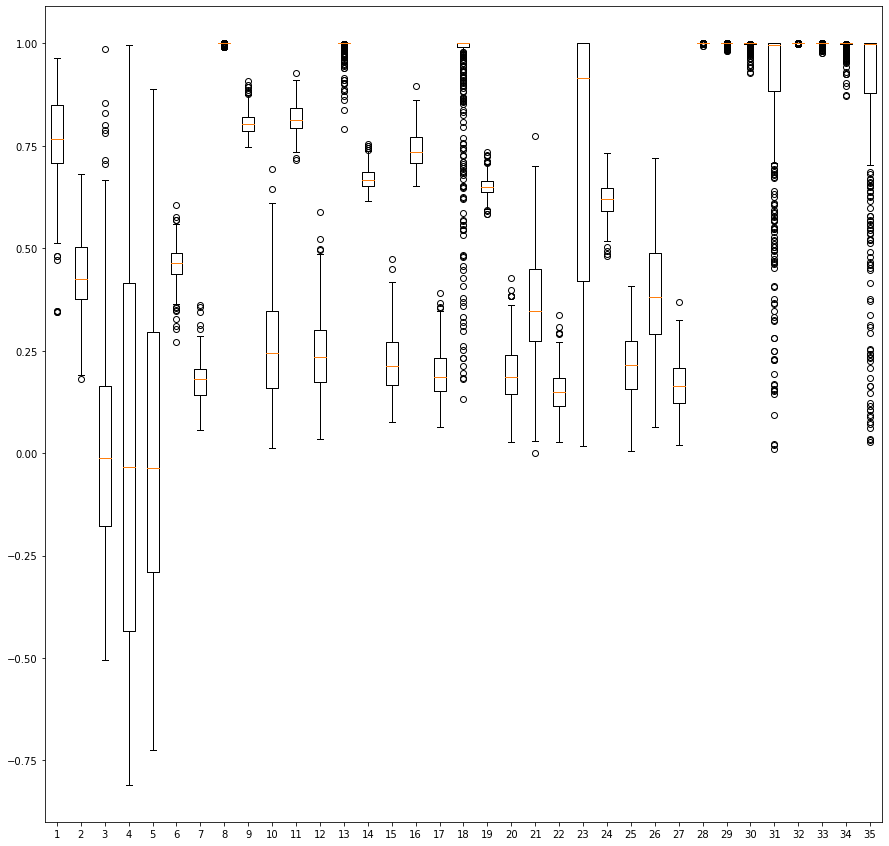

In [79]:
plt.figure(figsize=(15,15))
plt.boxplot(cl_n[cl_n.main_type == 'Orion_V*'][features]);

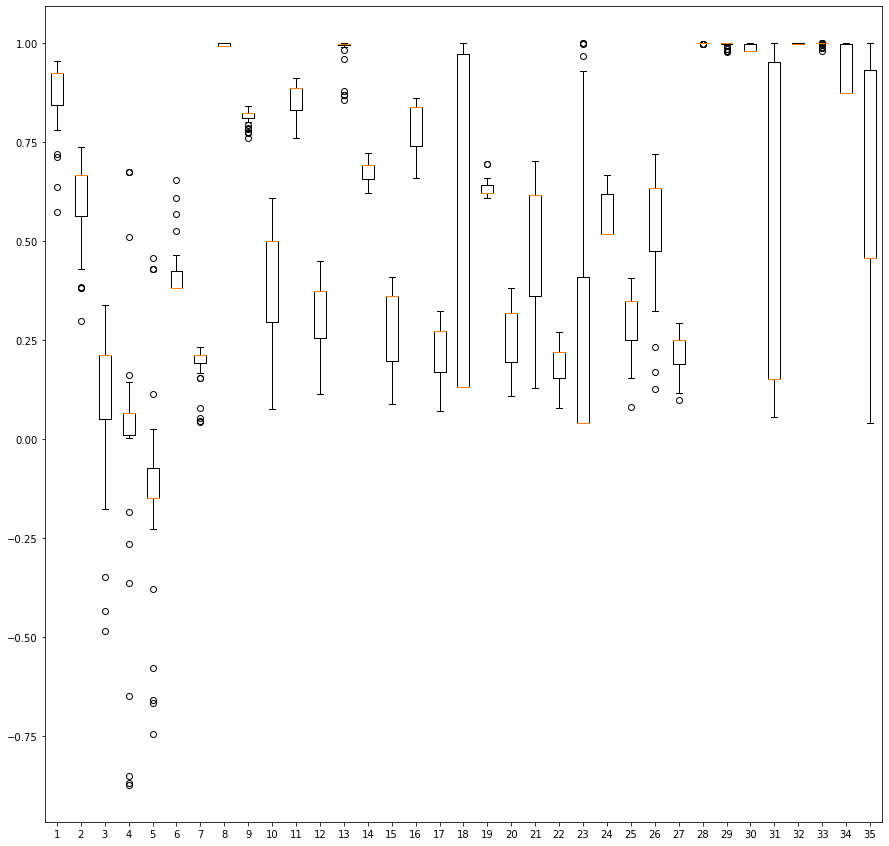

In [76]:
plt.figure(figsize=(15, 15))
plt.boxplot(cl_n_nans[cl_n_nans.main_type == 'BYDra'][features]);

# Question: Is the distribution similar to the clusterized obs?
# Send tables to Rafa.